<a href="https://colab.research.google.com/github/tri008/keras-io/blob/master/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patchify

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from numpy import expand_dims
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Divide each original image into 512 X 512 sizes with a 50% overlap.

In [ ]:
def split_patches(image_class):
  t=0
  dirname='/content/drive/MyDrive/Database/ICIAR2018_BACH_Challenge/Photos/'+image_class
  for fname in os.listdir(dirname):
    image=tiff.imread(dirname+fname)
    patches_img = patchify(image, (512, 512,3),step=256)
    for i in range(patches_img.shape[0]):
      for j in range(patches_img.shape[1]):
        t+=1
        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('/content/drive/MyDrive/Testdata/'+image_class+'_Split/' + 'Image_' +str(t)+ '.tif', single_patch_img)

Performing image augmentation by rotating each patch 90,180 and 270 degrees.Addtionally flip patches horizontally and vertically to generate a total of 5 images per patch.

In [ ]:
# a=0
def orthogonal_rot_90(image):
  return np.rot90(image, 1)
def orthogonal_rot_180(image):
  return np.rot90(image,2)
def orthogonal_rot_270(image):
  return np.rot90(image,3)

def rotate(image_class):
  dirname='/content/drive/MyDrive/Testdata/'+image_class+'_Split/'
  for fname in os.listdir(dirname):
    image=tiff.imread(dirname+fname)
    datagen = ImageDataGenerator(preprocessing_function=orthogonal_rot_90)
    i=0
    for batch in datagen.flow(image,batch_size=20,save_to_dir='/content/drive/MyDrive/Testdata/Rotated_'+image_class,save_prefix='aug'+str(k)+'r90',save_format='tif'):
      i+=1
      if i>0:
        break
    datagen = ImageDataGenerator(horizontal_flip=True)
    j=0
    for batch in datagen.flow(image,batch_size=20,save_to_dir='/content/drive/MyDrive/Testdata/Rotated_'+image_class,save_prefix='aug'+str(k)+'hor',save_format='tif'):
      j+=1
      if j>0:
        break
    datagen = ImageDataGenerator(vertical_flip=True)
    n=0
    for batch in datagen.flow(image,batch_size=20,save_to_dir='/content/drive/MyDrive/Testdata/Rotated_'+image_class,save_prefix='aug'+str(k)+'ver',save_format='tif'):
      n+=1
      if n>0:
        break
    datagen = ImageDataGenerator(preprocessing_function=orthogonal_rot_180)
    l=0
    for batch in datagen.flow(image,batch_size=20,save_to_dir='/content/drive/MyDrive/Testdata/Rotated_'+image_class,save_prefix='aug'+str(k)+'r180',save_format='tif'):
      l+=1
      if l>0:
        break
    datagen = ImageDataGenerator(preprocessing_function=orthogonal_rot_270)
    m=0
    for batch in datagen.flow(image,batch_size=20,save_to_dir='/content/drive/MyDrive/Testdata/Rotated_'+image_class,save_prefix='aug'+str(k)+'r270',save_format='tif'):
      m+=1
      if m>0:
        break

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = (512, 512,3)



Pretraining ResNet50 model on ImageNet

In [ ]:
resnet = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


Freezing the pretrained weights and removing last few layers.

In [ ]:
for layer in resnet.layers:
    layer.trainable = False
model=Model(inputs=resnet.input, outputs=resnet.layers[-5].output)
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           



*   Add Dropout layers to get better validation peformance
*   A Dense layer with softmax activation is also added so as to predict probabilities of different classes.
*   Sparse Categorical Crossentropy was used as loss funtion,since classes already have integer labels and do not require one-hot encoding.




In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential     1
from keras import optimizers
model1=Sequential()

# model.add(tf.keras.layers.GlobalAveragePooling2D())
model1.add(model)
model1.add(Flatten())
model1.add(Dense(512, activation='relu', input_dim=IMAGE_SIZE))
model1.add(Dropout(0.3))

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(4, activation='softmax'))
model1.summary()
model1.compile(optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.0001, momentum=0.9, nesterov=True, name="SGD"
),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['sparse_categorical_accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 16, 16, 512)       22528896  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2

Split training and validation datasets with a 80:20 split.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen1=ImageDataGenerator(validation_split=0.2,brightness_range=(0.2, 1.0))
import tifffile as tif
training_set1 = train_datagen1.flow_from_directory('/content/drive/MyDrive/DataTest',target_size = (512, 512),batch_size = 32,class_mode = 'sparse',subset='training')
test_set1=train_datagen1.flow_from_directory('/content/drive/MyDrive/DataTest',target_size = (512, 512),batch_size = 32,class_mode = 'sparse',subset='validation')

Found 46076 images belonging to 4 classes.
Found 11518 images belonging to 4 classes.


In [ ]:
import tifffile as tiff
history=model1.fit(training_set1,epochs=50,validation_data=test_set1,steps_per_epoch=len(training_set1)//32,validation_steps=len(test_set1)//32)

Epoch 1/50
45/45 [==============================] - 896s 20s/step - loss: 1.3641 - sparse_categorical_accuracy: 0.3146 - val_loss: 1.3016 - val_sparse_categorical_accuracy: 0.3864
Epoch 2/50
45/45 [==============================] - 853s 19s/step - loss: 1.2457 - sparse_categorical_accuracy: 0.4500 - val_loss: 1.2305 - val_sparse_categorical_accuracy: 0.4290
Epoch 3/50
45/45 [==============================] - 815s 18s/step - loss: 1.1386 - sparse_categorical_accuracy: 0.5097 - val_loss: 1.1681 - val_sparse_categorical_accuracy: 0.4517
Epoch 4/50
45/45 [==============================] - 789s 18s/step - loss: 1.0877 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.1679 - val_sparse_categorical_accuracy: 0.4517
Epoch 5/50
45/45 [==============================] - 780s 17s/step - loss: 1.0894 - sparse_categorical_accuracy: 0.5403 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.4830
Epoch 6/50
45/45 [==============================] - 736s 16s/step - loss: 1.0316 - sparse_categorica

KeyboardInterrupt: ignored

Training was stopped since no meaningful change in validation accuracy ocurrs

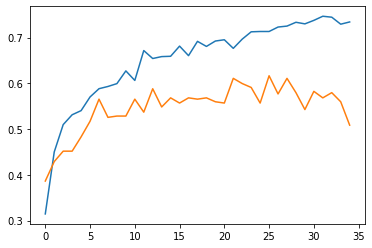

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model1.history.history['sparse_categorical_accuracy'])
plt.plot(model1.history.history['val_sparse_categorical_accuracy'])